# Improvements to be made in the future 

1. replace batch_norm with inst_norm2.
2. add resnet skip_connections in bottleneck
3. add ssim_loss + psnr_loss
4. vgg missing proper intialization
5. cache before prefetch
6. add discriminator feature loss
7. add patchgan discriminator
8. use l1 to measure difference in vgg pretrained loss
9. ttur learning rate lr_disc > lr_gen
10. beta1=0.0 to help adversarial game

* this notebook was old fast prototype but still yield great results on validation


In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [2]:
def normalize(img, mask):
    img = tf.cast(img, dtype=tf.float32) / 127.5 - 1.0  # Normalize images to [-1,1]
    mask = tf.cast(mask, dtype=tf.float32)/ 127.5 - 1.0  # Keep masks unchanged
    return img, mask

def denormalize(img):
        return (img + 1) / 2

In [3]:

# Define paths
#GoPro
sharp_train_path = "/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/train/sharp"
blur_train_path = "/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/train/blur"
sharp_test_path = "/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/test/sharp"
blur_test_path = "/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro/test/blur"

#Text_OCR
sharp_train_path_Text_OCR = "/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/TextOCR/train/sharp"
blur_train_path_Text_OCR = "/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/TextOCR/train/blur"
sharp_test_path_Text_OCR = "/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/TextOCR/test/sharp"
blur_test_path_Text_OCR = "/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/TextOCR/test/blur"

#Wider-Face
sharp_train_path_WF = "/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Wider-Face/train/sharp"
blur_train_path_WF = "/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Wider-Face/train/blur"
sharp_test_path_WF = "/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Wider-Face/test/sharp"
blur_test_path_WF = "/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Wider-Face/test/blur"

#Helen
sharp_train_path_H = "/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Helen/train/sharp"
blur_train_path_H = "/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Helen/train/blur"
sharp_test_path_H = "/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Helen/test/sharp"
blur_test_path_H = "/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Helen/test/blur"

# Set batch size and image size
BATCH_SIZE = 16
IMG_SIZE = (256, 256)

# Function to normalize images and masks

# Load images and masks (batch early for efficiency)
sharp_train_GoPro = tf.keras.utils.image_dataset_from_directory(
    sharp_train_path,
    label_mode=None,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False# ✅ Batch early
)
blur_train_GoPro = tf.keras.utils.image_dataset_from_directory(
    blur_train_path,
    label_mode=None,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False# ✅ Batch early
)
sharp_test_GoPro = tf.keras.utils.image_dataset_from_directory(
    sharp_test_path,
    label_mode=None,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False# ✅ Batch early
)
blur_test_GoPro = tf.keras.utils.image_dataset_from_directory(
    blur_test_path,
    label_mode=None,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False# ✅ Batch early
)


#--------------------------------------------------------------
#LIMIT_SAMPLES = 5000
#LIMIT_BATCHES = LIMIT_SAMPLES // BATCH_SIZE  # ~312 for batch size 16

sharp_train_Text_OCR = tf.keras.utils.image_dataset_from_directory(
    sharp_train_path_Text_OCR,
    label_mode=None,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)#.take(LIMIT_BATCHES)

blur_train_Text_OCR = tf.keras.utils.image_dataset_from_directory(
    blur_train_path_Text_OCR,
    label_mode=None,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)#.take(LIMIT_BATCHES)
sharp_test_Text_OCR = tf.keras.utils.image_dataset_from_directory(
    sharp_test_path_Text_OCR,
    label_mode=None,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False# ✅ Batch early
)
blur_test_Text_OCR = tf.keras.utils.image_dataset_from_directory(
    blur_test_path_Text_OCR,
    label_mode=None,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False# ✅ Batch early
)
#-------------------------------------
# Load Wider-Face
sharp_train_WF = tf.keras.utils.image_dataset_from_directory(
    sharp_train_path_WF,
    label_mode=None,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)
blur_train_WF = tf.keras.utils.image_dataset_from_directory(
    blur_train_path_WF,
    label_mode=None,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)
sharp_test_WF = tf.keras.utils.image_dataset_from_directory(
    sharp_test_path_WF,
    label_mode=None,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)
blur_test_WF = tf.keras.utils.image_dataset_from_directory(
    blur_test_path_WF,
    label_mode=None,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)
#------------------------------------
# Load Helen dataset
sharp_train_H = tf.keras.utils.image_dataset_from_directory(
    sharp_train_path_H,
    label_mode=None,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)
blur_train_H = tf.keras.utils.image_dataset_from_directory(
    blur_train_path_H,
    label_mode=None,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)
sharp_test_H = tf.keras.utils.image_dataset_from_directory(
    sharp_test_path_H,
    label_mode=None,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)
blur_test_H = tf.keras.utils.image_dataset_from_directory(
    blur_test_path_H,
    label_mode=None,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

#concat
#-------
# Concatenate all 4 datasets
# Concatenate ALL datasets: GoPro + Text_OCR + Wider-Face + Helen
blur_train = (
    blur_train_GoPro
    .concatenate(blur_train_Text_OCR)
    .concatenate(blur_train_WF)
    .concatenate(blur_train_H)
)

sharp_train = (
    sharp_train_GoPro
    .concatenate(sharp_train_Text_OCR)
    .concatenate(sharp_train_WF)
    .concatenate(sharp_train_H)
)

blur_test = (
    blur_test_GoPro
    .concatenate(blur_test_Text_OCR)
    .concatenate(blur_test_WF)
    .concatenate(blur_test_H)
)

sharp_test = (
    sharp_test_GoPro
    .concatenate(sharp_test_Text_OCR)
    .concatenate(sharp_test_WF)
    .concatenate(sharp_test_H)
)


#turn into pairs
#---------------
train_dataset = tf.data.Dataset.zip((blur_train, sharp_train))
val_dataset = tf.data.Dataset.zip((blur_test, sharp_test))
#Normalize
#---------------
train_dataset = train_dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
#cache
#train_dataset = train_dataset.cache().prefetch(tf.data.AUTOTUNE)



Found 2103 files.
Found 2103 files.
Found 1111 files.
Found 1111 files.
Found 5000 files.
Found 5000 files.
Found 500 files.
Found 500 files.
Found 4530 files.
Found 4530 files.
Found 567 files.
Found 567 files.
Found 2000 files.
Found 2000 files.
Found 165 files.
Found 165 files.


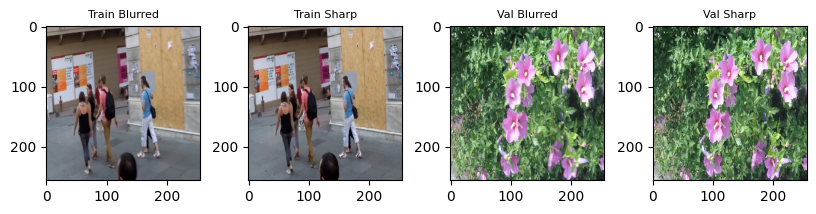

In [4]:
size = len(list(train_dataset.take(1).unbatch()))
rand_index = np.random.randint(0,size-1)
for (blurred_train,sharp_train),(blurred_val,sharp_val) in zip(train_dataset.take(1),val_dataset.take(1)):
    plt.figure(figsize=(10,2))
    plt.subplot(1,4,1)
    plt.imshow(denormalize(blurred_train[rand_index]))
    plt.title(f"Train Blurred",fontsize=8)

    plt.subplot(1,4,2)
    plt.imshow(denormalize(sharp_train[rand_index]))
    plt.title("Train Sharp",fontsize=8)

    plt.subplot(1,4,3)
    plt.imshow(denormalize(blurred_val[rand_index]))
    plt.title("Val Blurred",fontsize=8)

    plt.subplot(1,4,4)
    plt.imshow(denormalize(sharp_val[rand_index]))
    plt.title("Val Sharp",fontsize=8)

In [5]:
def DownSample(inputs, filters, kernel_size=4, strides=2, activation=None, inst_norm=False):
    x = tf.keras.layers.SpectralNormalization(tf.keras.layers.Conv2D(filters=filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same'),power_iterations=5)(inputs)
    if inst_norm:
        x = tf.keras.layers.GroupNormalization(groups=filters)(x)
    if activation == 'relu':
        x = tf.keras.layers.Activation('relu')(x)
    if activation == 'leakyrelu':
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    return x

def UpSample(inputs, paired_inputs, filters, kernel_size=4, strides=2, activation=None,inst_norm=False):
        # Transposed convolution layer.
        x = tf.keras.layers.Conv2DTranspose(filters=filters,
                               kernel_size=kernel_size,
                               strides=strides,
                               padding='same')(inputs)
        if inst_norm:
            x = tf.keras.layers.GroupNormalization(groups=filters)(x)
        if activation == 'relu':
            x = tf.keras.layers.Activation('relu')(x)
        elif activation == 'leakyrelu':
            x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        x = tf.keras.layers.Concatenate()([x, paired_inputs])
        return x
def ReLUBlock(inputs, filters,dilation_rate, kernel_size=4, inst_norm=False):
    x = tf.keras.layers.Conv2D(filters=filters,
                               kernel_size=kernel_size,
                               dilation_rate=dilation_rate,
                               padding='same')(inputs)
    
    if inst_norm:
        x = tf.keras.layers.GroupNormalization(groups=filters)(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Additional conv + norm + activation layer
    x = tf.keras.layers.Conv2D(filters=filters,
                               kernel_size=kernel_size,
                               dilation_rate=dilation_rate,
                               padding='same')(x)
    
    if inst_norm:
         x = tf.keras.layers.GroupNormalization(groups=filters)(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Match input shape if needed for residual connection
    if inputs.shape[-1] != filters:
        inputs = tf.keras.layers.Conv2D(filters, 1, padding='same')(inputs)
    
    return tf.keras.layers.Add()([inputs, x])


    

In [6]:
def build_generator(input_shape,down_sample_factor=64,name=None):
     inputs = tf.keras.layers.Input(shape=input_shape)
     e1 = DownSample(inputs,down_sample_factor,kernel_size=4,activation='leakyrelu',strides=1,inst_norm=False)
     e2 = DownSample(e1,down_sample_factor*2,kernel_size=4,activation='leakyrelu',strides=2,inst_norm=True)
     e3 = DownSample(e2,down_sample_factor*3,kernel_size=4,activation='leakyrelu',strides=2,inst_norm=True)
     e4 = DownSample(e3,down_sample_factor*4,kernel_size=4,activation='leakyrelu',strides=2,inst_norm=True)

     #BOTTLENECK
     e6 = DownSample(e4,down_sample_factor*5,kernel_size=4,activation='leakyrelu',strides=2,inst_norm=True)
     b1 = ReLUBlock(e6,down_sample_factor*6,dilation_rate=2,kernel_size=4,inst_norm=True)
     b2 = ReLUBlock(b1,down_sample_factor*6,dilation_rate=4,kernel_size=4,inst_norm=True)
     b3 = ReLUBlock(b2,down_sample_factor*6,dilation_rate=4,kernel_size=4,inst_norm=True)
    

     d1 = UpSample(b3,e4,512,kernel_size=4,strides=2,activation='leakyrelu',inst_norm=True)
     d2 = UpSample(d1,e3,256,kernel_size=4,strides=2,activation='leakyrelu',inst_norm=True)
     d3 = UpSample(d2,e2,128,kernel_size=4,strides=2,activation='leakyrelu',inst_norm=True)
     d4 = UpSample(d3,e1,64,kernel_size=4,strides=2,activation='leakyrelu',inst_norm=True)
     outputs = tf.keras.layers.Conv2DTranspose(3,kernel_size=4,strides=1,activation='tanh',
     padding='same')(d4)
     return tf.keras.models.Model(inputs, outputs, name=name)
    
def build_discriminator(input_shape,Target_shape, name=None):
    Inputs = tf.keras.layers.Input(shape=input_shape)
    Targets = tf.keras.layers.Input(shape=Target_shape)
    concat = tf.keras.layers.Concatenate()([Inputs,Targets])
    e1 = DownSample(concat,64,kernel_size=4,activation='leakyrelu',strides=2,inst_norm=False)
    e2 = DownSample(e1,128,kernel_size=4,activation='leakyrelu',strides=2,inst_norm=True)
    e3 = DownSample(e2,256,kernel_size=4,activation='leakyrelu',strides=2,inst_norm=True)
    e4 = DownSample(e3,512,kernel_size=4,activation='leakyrelu',strides=2,inst_norm=True)
    PatchGAN = tf.keras.layers.Conv2D(1, kernel_size=4, strides=1, padding='same',activation='sigmoid')(e4)
    outputs = [e1,e2,e3,e4,PatchGAN]
    return tf.keras.models.Model([Inputs,Targets], outputs, name=name)

In [7]:
class FeatureMatchingLoss(tf.keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.mae = tf.keras.losses.MeanAbsoluteError()

    def call(self, y_true, y_pred):
        loss = 0
        for i in range(len(y_true) - 1):
            loss += self.mae(y_true[i], y_pred[i])
        return loss

class VGGFeatureMatchingLoss(tf.keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.encoder_layers = [
            "block1_conv1",
            "block2_conv1",
            "block3_conv1",
            "block4_conv1",
            "block5_conv1",
        ]
        self.weights = [1.0 / 32, 1.0 / 16, 1.0 / 8, 1.0 / 4, 1.0]
        vgg = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
        layer_outputs = [vgg.get_layer(x).output for x in self.encoder_layers]
        self.vgg_model = tf.keras.Model(vgg.input, layer_outputs, name="VGG")
        self.mae = tf.keras.losses.MeanAbsoluteError()

    def call(self, y_true, y_pred):
        y_true = tf.keras.applications.vgg19.preprocess_input(127.5 * (y_true + 1))
        y_pred = tf.keras.applications.vgg19.preprocess_input(127.5 * (y_pred + 1))
        real_features = self.vgg_model(y_true)
        fake_features = self.vgg_model(y_pred)
        loss = 0
        for i in range(len(real_features)):
            loss += self.weights[i] * self.mae(real_features[i], fake_features[i])
        return loss

In [11]:
class Deblur_gan(tf.keras.Model):
    def __init__(self, generator, discriminator1, discriminator2, discriminator3):
        super().__init__()
        self.generator = generator
        self.discriminator1 = discriminator1
        self.discriminator2 = discriminator2
        self.discriminator3 = discriminator3
        self.FeatureMatchingLoss = FeatureMatchingLoss()
        self.VGGFeatureMatchingLoss = VGGFeatureMatchingLoss()

    def compile(self, g_optimizer, d_optimizer1, d_optimizer2, d_optimizer3):
        super().compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer1 = d_optimizer1
        self.d_optimizer2 = d_optimizer2
        self.d_optimizer3 = d_optimizer3



    @tf.function
    def train_step(self,batch_data):
          real_x, real_y = batch_data
          with tf.GradientTape(persistent=True) as gen_tape, \
                 tf.GradientTape() as disc_tape1, \
                 tf.GradientTape() as disc_tape2, \
                 tf.GradientTape() as disc_tape3:
                fake_y = self.generator(real_x, training=True)
    
              # --- Discriminator Losses ---
                # Scale 1: Original resolution (e.g., 256x256)
                disc_real_256 = self.discriminator1([real_x, real_y], training=True)
                disc_fake_256 = self.discriminator1([real_x, fake_y], training=True)
                disc_loss1 = tf.reduce_mean(tf.square(disc_real_256[-1] - 1)) + tf.reduce_mean(tf.square(disc_fake_256[-1]))
                feature_disc_256 = self.FeatureMatchingLoss(disc_real_256[:-1],disc_fake_256[:-1])
                     
    
                # Scale 2: Mid resolution (e.g., 128x128)
                real_x128 = tf.image.resize(real_x, [128, 128], method='bilinear')
                real_y128 = tf.image.resize(real_y, [128, 128], method='bilinear')
                fake_y128 = tf.image.resize(fake_y, [128, 128], method='bilinear')  # Downsample from original!
                
                disc_real_128 = self.discriminator2([real_x128, real_y128], training=True)
                disc_fake_128 = self.discriminator2([real_x128, fake_y128], training=True)
                disc_loss2 = tf.reduce_mean(tf.square(disc_real_128[-1] - 1)) + tf.reduce_mean(tf.square(disc_fake_128[-1]))
                feature_disc_128 = self.FeatureMatchingLoss(disc_real_128[:-1],disc_fake_128[:-1])
    
                # Scale 3: Low resolution (e.g., 64x64)
                real_x64 = tf.image.resize(real_x, [64, 64], method='bilinear')  # Downsample from original!
                real_y64 = tf.image.resize(real_y, [64, 64], method='bilinear')
                fake_y64 = tf.image.resize(fake_y, [64, 64], method='bilinear')
                
                disc_real_64 = self.discriminator3([real_x64, real_y64], training=True)
                disc_fake_64 = self.discriminator3([real_x64, fake_y64], training=True)
                disc_loss3 = tf.reduce_mean(tf.square(disc_real_64[-1] - 1)) + tf.reduce_mean(tf.square(disc_fake_64[-1]))
                feature_disc_64 = self.FeatureMatchingLoss(disc_real_64[:-1],disc_fake_64[:-1])
    
                # --- Generator Loss ---
                # Adversarial loss from all scales
                gen_loss1 = tf.reduce_mean(tf.square(disc_fake_256[-1] - 1))
                gen_loss2 = tf.reduce_mean(tf.square(disc_fake_128[-1] - 1))
                gen_loss3 = tf.reduce_mean(tf.square(disc_fake_64[-1] - 1))
                
                # L1 loss (only on original scale)
                l1_loss = tf.reduce_mean(tf.abs(real_y - fake_y))
                #perceptual_loss
                perceptual_loss = self.VGGFeatureMatchingLoss(real_y,fake_y)

                #peak to signal ratio loss
                ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(real_y, fake_y, max_val=1.0))
                psnr_loss = 1- tf.reduce_mean(tf.image.psnr(real_y,fake_y,max_val=1.0))

                
                # Total generator loss (weighted sum)
                total_gen_loss = (
                gen_loss1 + gen_loss2 + gen_loss3 +
                l1_loss +
                10 * feature_disc_256 +
                10 * feature_disc_128 +
                10 * feature_disc_64 +
                0.1 * perceptual_loss +
                ssim_loss
                )
    
    
            # --- Update Discriminators ---
          disc_grads1 = disc_tape1.gradient(disc_loss1, self.discriminator1.trainable_variables)
          self.d_optimizer1.apply_gradients(zip(disc_grads1, self.discriminator1.trainable_variables))
            
          disc_grads2 = disc_tape2.gradient(disc_loss2, self.discriminator2.trainable_variables)
          self.d_optimizer2.apply_gradients(zip(disc_grads2, self.discriminator2.trainable_variables))
            
          disc_grads3 = disc_tape3.gradient(disc_loss3, self.discriminator3.trainable_variables)
          self.d_optimizer3.apply_gradients(zip(disc_grads3, self.discriminator3.trainable_variables))
    
            # --- Update Generator ---
          gen_grads = gen_tape.gradient(total_gen_loss, self.generator.trainable_variables)
          self.g_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
    
          del gen_tape
          return {
                "D1_loss": disc_loss1,
                "D2_loss": disc_loss2,
                "D3_loss": disc_loss3,
                "G_loss": total_gen_loss,
                "L1_loss": l1_loss,
                "Perceptual loss":perceptual_loss,
                "Ssim_loss":ssim_loss,
                "Psnr_loss":psnr_loss
          }
    


In [12]:
class VisualizationCallback(tf.keras.callbacks.Callback):
    def __init__(self, generator, val_dataset, denormalize, num_samples=2):
        """
        Callback to visualize predictions during training.
        
        Args:
        - generator: The trained generator model.
        - val_dataset: Validation dataset (paired: (blurred, sharp)).
        - denormalize: Function to denormalize images.
        - num_samples: Number of images to visualize.
        """
        self.generator = generator
        self.val_dataset = val_dataset
        self.denormalize = denormalize
        self.num_samples = num_samples

    def on_epoch_end(self, epoch, logs=None):
        # Get a batch from validation dataset
        if epoch % 5 == 0 :
            for blurred, sharp in self.val_dataset.take(1):  # Take 1 batch
                blurred = blurred[:self.num_samples]  # Select `num_samples` images
                sharp = sharp[:self.num_samples]
    
                # Generate predictions
                predicted = self.generator(blurred, training=False)
    
    
                # Plot images
                fig, axes = plt.subplots(self.num_samples, 3, figsize=(5, 2 * self.num_samples))
    
                for i in range(self.num_samples):
                    axes[i, 0].imshow(denormalize(blurred[i]))   # Blurred input
                    axes[i, 0].axis("off")
    
                    axes[i, 1].imshow(denormalize(sharp[i]))     # Ground Truth
                    axes[i, 1].axis("off")
    
                    axes[i, 2].imshow(denormalize(predicted[i])) # Model Prediction
                    axes[i, 2].axis("off")
                    
                plt.tight_layout()
                plt.savefig(f"epoch{epoch}")
                plt.close()

class Save_Weights(tf.keras.callbacks.Callback):
    def __init__(self,g1):
        self.g1 = g1

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:  # Save weights every 5 epochs
            self.g1.save(f"Generator_LowRes_Epoch_{epoch}.h5")


In [13]:
g1 = build_generator((256,256,3))
d1 = build_discriminator((256,256,3),(256,256,3))
d2 = build_discriminator((128,128,3),(128,128,3))
d3 = build_discriminator((64,64,3),(64,64,3))
Deblur_gan_model = Deblur_gan(g1,d1,d2,d3)
g1.summary()
d1.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spectral_normalization    │ (None, 256, 256, 64)   │          3,200 │ input_layer[0][0]      │
│ (SpectralNormalization)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 256, 256, 64)   │              0 │ spectral_normalizatio… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spectral_normalization_1  │ (None, 128, 128, 128)  │        131,328 │ leaky_re_lu[0][0]      │
│ (SpectralNormalization)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization       │ (None, 128, 128, 128)  │            256 │ spectral_normalizatio… │
│ (GroupNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 128, 128, 128)  │              0 │ group_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spectral_normalization_2  │ (None, 64, 64, 192)    │        393,600 │ leaky_re_lu_1[0][0]    │
│ (SpectralNormalization)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_1     │ (None, 64, 64, 192)    │            384 │ spectral_normalizatio… │
│ (GroupNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 64, 64, 192)    │              0 │ group_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spectral_normalization_3  │ (None, 32, 32, 256)    │        786,944 │ leaky_re_lu_2[0][0]    │
│ (SpectralNormalization)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_2     │ (None, 32, 32, 256)    │            512 │ spectral_normalizatio… │
│ (GroupNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 32, 32, 256)    │              0 │ group_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spectral_normalization_4  │ (None, 16, 16, 320)    │      1,311,360 │ leaky_re_lu_3[0][0]    │
│ (SpectralNormalization)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_3     │ (None, 16, 16, 320)    │            640 │ spectral_normalizatio… │
│ (GroupNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 16, 16, 320)    │              0 │ group_normalization_3… │
├──────────────────────

 Total params: 24,001,091 (91.56 MB)

 Trainable params: 24,000,131 (91.55 MB)

 Non-trainable params: 960 (3.75 KB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 256, 256, 6)    │              0 │ input_layer_1[0][0],   │
│ (Concatenate)             │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spectral_normalization_5  │ (None, 128, 128, 64)   │          6,272 │ concatenate_4[0][0]    │
│ (SpectralNormalization)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_9 (LeakyReLU) │ (None, 128, 128, 64)   │              0 │ spectral_normalizatio… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spectral_normalization_6  │ (None, 64, 64, 128)    │        131,328 │ leaky_re_lu_9[0][0]    │
│ (SpectralNormalization)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_14    │ (None, 64, 64, 128)    │            256 │ spectral_normalizatio… │
│ (GroupNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_10            │ (None, 64, 64, 128)    │              0 │ group_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spectral_normalization_7  │ (None, 32, 32, 256)    │        524,800 │ leaky_re_lu_10[0][0]   │
│ (SpectralNormalization)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_15    │ (None, 32, 32, 256)    │            512 │ spectral_normalizatio… │
│ (GroupNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_11            │ (None, 32, 32, 256)    │              0 │ group_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spectral_normalization_8  │ (None, 16, 16, 512)    │      2,098,176 │ leaky_re_lu_11[0][0]   │
│ (SpectralNormalization)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_16    │ (None, 16, 16, 512)    │          1,024 │ spectral_normalizatio… │
│ (GroupNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_12       

 Total params: 2,770,561 (10.57 MB)

 Trainable params: 2,769,601 (10.57 MB)

 Non-trainable params: 960 (3.75 KB)

In [14]:
#two time rule update
#--------------------
optimizer_d1 = tf.keras.optimizers.Adam(learning_rate=4e-4, beta_1=0.0, beta_2=0.999)
optimizer_d2 = tf.keras.optimizers.Adam(learning_rate=4e-4, beta_1=0.0, beta_2=0.999)
optimizer_d3 = tf.keras.optimizers.Adam(learning_rate=4e-4, beta_1=0.0, beta_2=0.999)
optimizer_g = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.0, beta_2=0.999) 
Deblur_gan_model.compile(optimizer_g,optimizer_d1,optimizer_d2,optimizer_d3)

In [15]:
vis_callback = VisualizationCallback(g1, val_dataset, denormalize)
weights_callback = Save_Weights(g1)

In [ ]:
Deblur_gan_model.fit(train_dataset, epochs=30, callbacks=[vis_callback,weights_callback])

Epoch 1/30
854/854 ━━━━━━━━━━━━━━━━━━━━ 2078s 2s/step - D1_loss: 0.4038 - D2_loss: 0.5232 - D3_loss: 0.5267 - G_loss: 25.9564 - L1_loss: 0.1204 - Perceptual loss: 118.7262 - Psnr_loss: -14.7345 - Ssim_loss: 0.4912
Epoch 2/30
854/854 ━━━━━━━━━━━━━━━━━━━━ 1069s 1s/step - D1_loss: 0.1830 - D2_loss: 0.4444 - D3_loss: 0.4901 - G_loss: 24.3587 - L1_loss: 0.0984 - Perceptual loss: 101.8243 - Psnr_loss: -15.9059 - Ssim_loss: 0.4109
Epoch 3/30
854/854 ━━━━━━━━━━━━━━━━━━━━ 1070s 1s/step - D1_loss: 0.4120 - D2_loss: 0.4294 - D3_loss: 0.4530 - G_loss: 21.2409 - L1_loss: 0.0969 - Perceptual loss: 97.9932 - Psnr_loss: -15.9078 - Ssim_loss: 0.4014
Epoch 4/30
854/854 ━━━━━━━━━━━━━━━━━━━━ 1070s 1s/step - D1_loss: 0.3324 - D2_loss: 0.4118 - D3_loss: 0.4507 - G_loss: 18.9226 - L1_loss: 0.0962 - Perceptual loss: 94.0509 - Psnr_loss: -15.9351 - Ssim_loss: 0.3964
Epoch 5/30
854/854 ━━━━━━━━━━━━━━━━━━━━ 1070s 1s/step - D1_loss: 0.2985 - D2_loss: 0.4049 - D3_loss: 0.4381 - G_loss: 17.4453 - L1_loss: 0.0944 - 

In [25]:
g.save("Deblur gen1.h5")
d.save("Deblur disc1.h5")